Note that the networks for this task could be pretrained on the classification task.

## Configuration

In [1]:
config = {
    # General
    'batchsize': 256,
    'shuffle': True,
    # Augmentations
    'flip': False,
    'ascale': True, 'as_min': 0.6667, 'as_max': 1.5,
    'rotate': False, 'r_positions': 12, 'test_pos': None,
    'translate': True, 't_rate': 0.1,
    # Point clouds and kd-trees generation
    'steps': 10, # also control the depth of the network
    'dim': 3,
    'lim': 1,
    'det': False,
    'gamma': 10.,
    # NN options
    'input_features': 'all', # 'all' for point coordinates, 'no' for feeding 1's as point features
    'n_f': [16, 
            32,  32,  
            64,  64,  
            128, 128, 
            256, 256, 
            512, 128], # representation sizes
    'n_groups': 32,  # -//-
    'min_cov': 1e-6, # parameters of histogram loss
    'bin_num': 256,  # -//-
    'l2': 1e-4,
    'lr': 1e-4,
    'n_ens': 16
}

## Load Data

In [2]:
import h5py as h5
import numpy as np

In [3]:
path2data = "./shapenet_normal.h5"
hf = h5.File(path2data, 'r')
train_vertices = np.array(hf.get('train_vertices'))
train_faces = hf.get('train_faces')
train_nFaces = np.array(hf.get('train_nFaces'))
train_names = np.array(hf.get('train_names'))
train_labels = np.array(hf.get('train_labels'))

val_vertices = np.array(hf.get('val_vertices'))
val_faces = hf.get('val_faces')
val_nFaces = np.array(hf.get('val_nFaces'))
val_names = np.array(hf.get('val_names'))
val_labels = np.array(hf.get('val_labels'))

test_vertices = np.array(hf.get('test_vertices'))
test_faces = hf.get('test_faces')
test_nFaces = np.array(hf.get('test_nFaces'))
test_names = np.array(hf.get('test_names'))

## Build Network

In [4]:
import theano.sandbox.cuda
theano.sandbox.cuda.use('gpu0')
import theano
import theano.tensor as T

from lasagne.layers import InputLayer, ReshapeLayer, NonlinearityLayer, ExpressionLayer
from lasagne.layers import ElemwiseSumLayer, ElemwiseMergeLayer
from lasagne.layers import DenseLayer
from lasagne.layers.dnn import BatchNormDNNLayer
from lasagne.nonlinearities import rectify, softmax

from lasagne.layers import get_output, get_all_params
from lasagne.regularization import regularize_network_params, l2
from lasagne.objectives import categorical_crossentropy, categorical_accuracy
from lasagne.updates import adam

from lib.nn.layers import SharedDotLayer, SPTNormReshapeLayer
from lib.nn.utils import dump_weights, load_weights, calc_hist_vals_vector, hist_loss

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 970 (CNMeM is enabled with initial size: 90.0% of memory, cuDNN 5110)


In [5]:
clouds = T.tensor3(dtype='float32')
norms = [T.tensor3(dtype='float32') for step in xrange(config['steps'])]
target = T.vector(dtype='int32')

KDNet = {}
if config['input_features'] == 'no':
    KDNet['input'] = InputLayer((None, 1, 2**config['steps']), input_var=clouds)
else:
    KDNet['input'] = InputLayer((None, 3, 2**config['steps']), input_var=clouds)
for i in xrange(config['steps']):
    KDNet['norm{}_r'.format(i+1)] = InputLayer((None, 3, 2**(config['steps']-1-i)), input_var=norms[i])
    KDNet['norm{}_l'.format(i+1)] = ExpressionLayer(KDNet['norm{}_r'.format(i+1)], lambda X: -X)

    KDNet['norm{}_l_X-'.format(i+1)] = SPTNormReshapeLayer(KDNet['norm{}_l'.format(i+1)], '-', 0, config['n_f'][i+1])
    KDNet['norm{}_l_Y-'.format(i+1)] = SPTNormReshapeLayer(KDNet['norm{}_l'.format(i+1)], '-', 1, config['n_f'][i+1])
    KDNet['norm{}_l_Z-'.format(i+1)] = SPTNormReshapeLayer(KDNet['norm{}_l'.format(i+1)], '-', 2, config['n_f'][i+1])
    KDNet['norm{}_l_X+'.format(i+1)] = SPTNormReshapeLayer(KDNet['norm{}_l'.format(i+1)], '+', 0, config['n_f'][i+1])
    KDNet['norm{}_l_Y+'.format(i+1)] = SPTNormReshapeLayer(KDNet['norm{}_l'.format(i+1)], '+', 1, config['n_f'][i+1])
    KDNet['norm{}_l_Z+'.format(i+1)] = SPTNormReshapeLayer(KDNet['norm{}_l'.format(i+1)], '+', 2, config['n_f'][i+1])
    KDNet['norm{}_r_X-'.format(i+1)] = SPTNormReshapeLayer(KDNet['norm{}_r'.format(i+1)], '-', 0, config['n_f'][i+1])
    KDNet['norm{}_r_Y-'.format(i+1)] = SPTNormReshapeLayer(KDNet['norm{}_r'.format(i+1)], '-', 1, config['n_f'][i+1])
    KDNet['norm{}_r_Z-'.format(i+1)] = SPTNormReshapeLayer(KDNet['norm{}_r'.format(i+1)], '-', 2, config['n_f'][i+1])
    KDNet['norm{}_r_X+'.format(i+1)] = SPTNormReshapeLayer(KDNet['norm{}_r'.format(i+1)], '+', 0, config['n_f'][i+1])
    KDNet['norm{}_r_Y+'.format(i+1)] = SPTNormReshapeLayer(KDNet['norm{}_r'.format(i+1)], '+', 1, config['n_f'][i+1])
    KDNet['norm{}_r_Z+'.format(i+1)] = SPTNormReshapeLayer(KDNet['norm{}_r'.format(i+1)], '+', 2, config['n_f'][i+1])

    KDNet['cloud{}'.format(i+1)] = SharedDotLayer(KDNet['input'], config['n_f'][i]) if i == 0 else \
                                   ElemwiseSumLayer([KDNet['cloud{}_l_X-_masked'.format(i)],
                                                     KDNet['cloud{}_l_Y-_masked'.format(i)],
                                                     KDNet['cloud{}_l_Z-_masked'.format(i)],
                                                     KDNet['cloud{}_l_X+_masked'.format(i)],
                                                     KDNet['cloud{}_l_Y+_masked'.format(i)],
                                                     KDNet['cloud{}_l_Z+_masked'.format(i)],
                                                     KDNet['cloud{}_r_X-_masked'.format(i)],
                                                     KDNet['cloud{}_r_Y-_masked'.format(i)],
                                                     KDNet['cloud{}_r_Z-_masked'.format(i)],
                                                     KDNet['cloud{}_r_X+_masked'.format(i)],
                                                     KDNet['cloud{}_r_Y+_masked'.format(i)],
                                                     KDNet['cloud{}_r_Z+_masked'.format(i)]])
    KDNet['cloud{}_bn'.format(i+1)] = BatchNormDNNLayer(KDNet['cloud{}'.format(i+1)])
    KDNet['cloud{}_relu'.format(i+1)] = NonlinearityLayer(KDNet['cloud{}_bn'.format(i+1)], rectify)

    KDNet['cloud{}_r'.format(i+1)] = ExpressionLayer(KDNet['cloud{}_relu'.format(i+1)],
                                                     lambda X: X[:, :, 1::2], 
                                                     (None, config['n_f'][i], 2**(config['steps']-i-1)))
    KDNet['cloud{}_l'.format(i+1)] = ExpressionLayer(KDNet['cloud{}_relu'.format(i+1)],
                                                     lambda X: X[:, :, ::2], 
                                                     (None, config['n_f'][i], 2**(config['steps']-i-1)))

    KDNet['cloud{}_l_X-'.format(i+1)] = SharedDotLayer(KDNet['cloud{}_l'.format(i+1)], config['n_f'][i+1])
    KDNet['cloud{}_l_Y-'.format(i+1)] = SharedDotLayer(KDNet['cloud{}_l'.format(i+1)], config['n_f'][i+1])
    KDNet['cloud{}_l_Z-'.format(i+1)] = SharedDotLayer(KDNet['cloud{}_l'.format(i+1)], config['n_f'][i+1])
    KDNet['cloud{}_l_X+'.format(i+1)] = SharedDotLayer(KDNet['cloud{}_l'.format(i+1)], config['n_f'][i+1])
    KDNet['cloud{}_l_Y+'.format(i+1)] = SharedDotLayer(KDNet['cloud{}_l'.format(i+1)], config['n_f'][i+1])
    KDNet['cloud{}_l_Z+'.format(i+1)] = SharedDotLayer(KDNet['cloud{}_l'.format(i+1)], config['n_f'][i+1])
    KDNet['cloud{}_r_X-'.format(i+1)] = SharedDotLayer(KDNet['cloud{}_r'.format(i+1)], config['n_f'][i+1],
                                                       W=KDNet['cloud{}_l_X-'.format(i+1)].W, 
                                                       b=KDNet['cloud{}_l_X-'.format(i+1)].b)
    KDNet['cloud{}_r_Y-'.format(i+1)] = SharedDotLayer(KDNet['cloud{}_r'.format(i+1)], config['n_f'][i+1],
                                                       W=KDNet['cloud{}_l_Y-'.format(i+1)].W, 
                                                       b=KDNet['cloud{}_l_Y-'.format(i+1)].b)
    KDNet['cloud{}_r_Z-'.format(i+1)] = SharedDotLayer(KDNet['cloud{}_r'.format(i+1)], config['n_f'][i+1],
                                                       W=KDNet['cloud{}_l_Z-'.format(i+1)].W, 
                                                       b=KDNet['cloud{}_l_Z-'.format(i+1)].b)
    KDNet['cloud{}_r_X+'.format(i+1)] = SharedDotLayer(KDNet['cloud{}_r'.format(i+1)], config['n_f'][i+1],
                                                       W=KDNet['cloud{}_l_X+'.format(i+1)].W,
                                                       b=KDNet['cloud{}_l_X+'.format(i+1)].b)
    KDNet['cloud{}_r_Y+'.format(i+1)] = SharedDotLayer(KDNet['cloud{}_r'.format(i+1)], config['n_f'][i+1],
                                                       W=KDNet['cloud{}_l_Y+'.format(i+1)].W,
                                                       b=KDNet['cloud{}_l_Y+'.format(i+1)].b)
    KDNet['cloud{}_r_Z+'.format(i+1)] = SharedDotLayer(KDNet['cloud{}_r'.format(i+1)], config['n_f'][i+1],
                                                       W=KDNet['cloud{}_l_Z+'.format(i+1)].W,
                                                       b=KDNet['cloud{}_l_Z+'.format(i+1)].b)

    KDNet['cloud{}_l_X-_masked'.format(i+1)] = ElemwiseMergeLayer([KDNet['cloud{}_l_X-'.format(i+1)],
                                                                   KDNet['norm{}_l_X-'.format(i+1)]], T.mul)
    KDNet['cloud{}_l_Y-_masked'.format(i+1)] = ElemwiseMergeLayer([KDNet['cloud{}_l_Y-'.format(i+1)],
                                                                   KDNet['norm{}_l_Y-'.format(i+1)]], T.mul)
    KDNet['cloud{}_l_Z-_masked'.format(i+1)] = ElemwiseMergeLayer([KDNet['cloud{}_l_Z-'.format(i+1)],
                                                                   KDNet['norm{}_l_Z-'.format(i+1)]], T.mul)
    KDNet['cloud{}_l_X+_masked'.format(i+1)] = ElemwiseMergeLayer([KDNet['cloud{}_l_X+'.format(i+1)],
                                                                   KDNet['norm{}_l_X+'.format(i+1)]], T.mul)
    KDNet['cloud{}_l_Y+_masked'.format(i+1)] = ElemwiseMergeLayer([KDNet['cloud{}_l_Y+'.format(i+1)],
                                                                   KDNet['norm{}_l_Y+'.format(i+1)]], T.mul)
    KDNet['cloud{}_l_Z+_masked'.format(i+1)] = ElemwiseMergeLayer([KDNet['cloud{}_l_Z+'.format(i+1)],
                                                                   KDNet['norm{}_l_Z+'.format(i+1)]], T.mul)
    KDNet['cloud{}_r_X-_masked'.format(i+1)] = ElemwiseMergeLayer([KDNet['cloud{}_r_X-'.format(i+1)],
                                                                   KDNet['norm{}_r_X-'.format(i+1)]], T.mul)
    KDNet['cloud{}_r_Y-_masked'.format(i+1)] = ElemwiseMergeLayer([KDNet['cloud{}_r_Y-'.format(i+1)],
                                                                   KDNet['norm{}_r_Y-'.format(i+1)]], T.mul)
    KDNet['cloud{}_r_Z-_masked'.format(i+1)] = ElemwiseMergeLayer([KDNet['cloud{}_r_Z-'.format(i+1)],
                                                                   KDNet['norm{}_r_Z-'.format(i+1)]], T.mul)
    KDNet['cloud{}_r_X+_masked'.format(i+1)] = ElemwiseMergeLayer([KDNet['cloud{}_r_X+'.format(i+1)],
                                                                   KDNet['norm{}_r_X+'.format(i+1)]], T.mul)
    KDNet['cloud{}_r_Y+_masked'.format(i+1)] = ElemwiseMergeLayer([KDNet['cloud{}_r_Y+'.format(i+1)],
                                                                   KDNet['norm{}_r_Y+'.format(i+1)]], T.mul)
    KDNet['cloud{}_r_Z+_masked'.format(i+1)] = ElemwiseMergeLayer([KDNet['cloud{}_r_Z+'.format(i+1)],
                                                                   KDNet['norm{}_r_Z+'.format(i+1)]], T.mul)

KDNet['cloud_fin'] = ElemwiseSumLayer([KDNet['cloud{}_l_X-_masked'.format(config['steps'])],
                                       KDNet['cloud{}_l_Y-_masked'.format(config['steps'])],
                                       KDNet['cloud{}_l_Z-_masked'.format(config['steps'])],
                                       KDNet['cloud{}_l_X+_masked'.format(config['steps'])],
                                       KDNet['cloud{}_l_Y+_masked'.format(config['steps'])],
                                       KDNet['cloud{}_l_Z+_masked'.format(config['steps'])],
                                       KDNet['cloud{}_r_X-_masked'.format(config['steps'])],
                                       KDNet['cloud{}_r_Y-_masked'.format(config['steps'])],
                                       KDNet['cloud{}_r_Z-_masked'.format(config['steps'])],
                                       KDNet['cloud{}_r_X+_masked'.format(config['steps'])],
                                       KDNet['cloud{}_r_Y+_masked'.format(config['steps'])],
                                       KDNet['cloud{}_r_Z+_masked'.format(config['steps'])]])
KDNet['desc'] = ReshapeLayer(KDNet['cloud_fin'], (-1, config['n_f'][-1]))
KDNet['desc_norm'] = ExpressionLayer(KDNet['desc'], lambda X: X / X.norm(2, axis=1).dimshuffle(0, 'x'))

# Loading weights (optional)
# load_weights('./models/RT+AS+TR+1e-3_15.pkl', KDNet['desc_norm'])

desc_norm = get_output(KDNet['desc_norm'])
desc_det = get_output(KDNet['desc_norm'], deterministic=True)

weights = get_all_params(KDNet['desc_norm'], trainable=True)
l2_pen = regularize_network_params(KDNet['desc_norm'], l2)

pos_mask = T.eq(target.dimshuffle('x', 0), target.dimshuffle(0, 'x'))
neg_mask = 1. - pos_mask

pos_ind0, pos_ind1 = pos_mask.nonzero()
neg_ind0, neg_ind1 = neg_mask.nonzero()

sim = desc_norm.dot(desc_norm.T)

sim_pos = sim[pos_ind0, pos_ind1]
sim_neg = sim[neg_ind0, neg_ind1]

hist_pos = calc_hist_vals_vector(sim_pos, 
                                 -1.0, 1.0, 
                                 (config['batchsize']**2)/config['n_groups'], 
                                 config['bin_num'], config['min_cov'])
hist_pos /= hist_pos.sum()
hist_neg = calc_hist_vals_vector(sim_neg, 
                                 -1.0, 1.0, 
                                 (config['batchsize']**2)/config['n_groups']*(config['n_groups'] - 1),
                                 config['bin_num'], config['min_cov'])
hist_neg /= hist_neg.sum()

HL = hist_loss(hist_neg, hist_pos, config['bin_num']) + config['l2']*l2_pen

lr = theano.shared(np.float32(config['lr']))
updates = adam(HL, weights, learning_rate=lr)

train_fun = theano.function([clouds] + norms + [target], HL, updates=updates)
desc_fun = theano.function([clouds] + norms, desc_det)

## Build Data Iterator

In [6]:
from lib.generators.meshgrid import generate_clouds
from lib.trees.kdtrees import KDTrees

In [45]:
def iterate_minibatches(*arrays, **kwargs):
    if kwargs['mode'] == 'train':
        _, p = np.unique(arrays[3], return_counts=True)
        p = np.float32(p)/p.sum()
        labels = np.empty((len(arrays[2]) - 1)/kwargs['batchsize']*kwargs['n_groups'], dtype=np.int32)
        for i in xrange((len(arrays[2]) - 1)/kwargs['batchsize']):
            labels[kwargs['n_groups']*i:kwargs['n_groups']*(i+1)] = \
                np.random.choice(np.arange(arrays[3].max() + 1),
                                 size=kwargs['n_groups'], 
                                 replace=False, p=p)
        indices = np.empty((len(arrays[2]) - 1)/kwargs['batchsize']*kwargs['batchsize'], dtype=np.int32)
        for i, label in enumerate(labels):
            indices[(kwargs['batchsize']/kwargs['n_groups'])*i:(kwargs['batchsize']/kwargs['n_groups'])*(i+1)] = \
                np.random.choice((arrays[3] == label).nonzero()[0], 
                                 size=(kwargs['batchsize']/kwargs['n_groups']), 
                                 replace=False)
    elif kwargs['mode'] == 'test':
        indices = np.arange(len(arrays[2]) - 1)
        if kwargs['shuffle']:
            np.random.shuffle(indices)
        
    for start_idx in xrange(0, len(indices), kwargs['batchsize']):
        excerpt = indices[start_idx:start_idx + kwargs['batchsize']]
        tmp = generate_clouds(excerpt, kwargs['steps'], arrays[0], arrays[1], arrays[2])
        
        if kwargs['flip']:
            flip = np.random.random(size=(len(tmp), 2, 1))
            flip[flip >= 0.5] = 1.
            flip[flip < 0.5] = -1.
            tmp[:, :2] *= flip
        
        if kwargs['ascale']:
            tmp *= (kwargs['as_min'] + (kwargs['as_max'] - kwargs['as_min'])*np.random.random(size=(len(tmp), kwargs['dim'], 1)))
            tmp /= np.fabs(tmp).max(axis=(1, 2), keepdims=True)
            
        if kwargs['rotate']:
            r = np.sqrt((tmp[:, :2]**2).sum(axis=1))
            coss = tmp[:, 0]/r
            sins = tmp[:, 1]/r
            
            if kwargs['test_pos'] is not None:
                alpha = 2*np.pi*kwargs['test_pos']/kwargs['r_positions']
            else:
                alpha = 2*np.pi*np.random.randint(0, kwargs['r_positions'], (len(tmp), 1))/kwargs['positions']
                
            cosr = np.cos(alpha)
            sinr = np.sin(alpha)
            cos = coss*cosr - sins*sinr
            sin = sins*cosr + sinr*coss
            tmp[:, 0] = r*cos
            tmp[:, 1] = r*sin
            
        if kwargs['translate']:
            mins = tmp.min(axis=2, keepdims=True)
            maxs = tmp.max(axis=2, keepdims=True)
            rngs = maxs - mins
            tmp += kwargs['t_rate']*(np.random.random(size=(len(tmp), kwargs['dim'], 1)) - 0.5)*rngs
        
        trees_data = KDTrees(tmp, dim=kwargs['dim'], steps=kwargs['steps'], 
                             lim=kwargs['lim'], det=kwargs['det'], gamma=kwargs['gamma'])
            
        sortings, normals = trees_data['sortings'], trees_data['normals']
        
        if kwargs['input_features'] == 'all':
            clouds = np.empty((len(excerpt), kwargs['dim'], 2**kwargs['steps']), dtype=np.float32)
            for i, srt in enumerate(sortings):
                clouds[i] = tmp[i, :, srt].T
        elif kwargs['input_features'] == 'no':
            clouds = np.ones((len(excerpt), 1, 2**kwargs['steps']), dtype=np.float32)
        
        if kwargs['mode'] == 'train':
            yield [clouds] + normals[::-1] + [arrays[3][excerpt]]
        if kwargs['mode'] == 'test':
            yield [clouds] + normals[::-1] + [excerpt]

## Prediction  function

In [53]:
def sim_fun(vertices, faces, nFaces, **kwargs):
    sim_sum = np.zeros((len(nFaces)-1, len(nFaces)-1), dtype=np.float32)
    for ens in xrange(kwargs['n_ens']):
        descs = np.zeros((len(nFaces)-1, kwargs['n_f'][-1]), dtype=np.float32)    
        for i, batch in enumerate(iterate_minibatches(vertices, faces, nFaces, **kwargs)):
            descs[batch[-1]] = desc_fun(batch[0], 
                                        batch[1], batch[2], batch[3], batch[4], batch[5], 
                                        batch[6], batch[7], batch[8], batch[9], batch[10])
        sim_sum += descs.dot(descs.T)
    return sim_sum / kwargs['n_ens']


def calc_hist(sim, labels, bin_num=256):
    brd = np.linspace(-1., 1., bin_num+1)
    pos_mask = labels.reshape(1, -1) == labels.reshape(-1, 1)
    neg_mask = np.logical_not(pos_mask)
    
    pos_hist = np.empty(bin_num, dtype=np.float32)
    neg_hist = np.empty(bin_num, dtype=np.float32)
    
    for i in xrange(bin_num):
        left_cond = brd[i] <= sim
        right_cond = sim <= brd[i+1]
        buf_bin = np.logical_and(left_cond, right_cond)
        pos_hist[i] = np.float32(pos_mask*buf_bin).sum()
        neg_hist[i] = np.float32(neg_mask*buf_bin).sum()
    
    pos_hist /= pos_hist.sum()
    neg_hist /= neg_hist.sum()
    return neg_hist, pos_hist

## Train

In [48]:
from sys import stdout
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

config['mode'] = 'train'

Epoch progress: 35584/35584		Loss: 0.13937
Epoch 1 of 50 took 262.979s
  training loss (in-iteration):		0.139370
Epoch progress: 35584/35584		Loss: 0.13624
Epoch 2 of 50 took 260.218s
  training loss (in-iteration):		0.136243
Epoch progress: 35584/35584		Loss: 0.13350
Epoch 3 of 50 took 260.458s
  training loss (in-iteration):		0.133502
Epoch progress: 35584/35584		Loss: 0.12974
Epoch 4 of 50 took 260.046s
  training loss (in-iteration):		0.129744
Epoch progress: 35584/35584		Loss: 0.12672
Epoch 5 of 50 took 261.382s
  training loss (in-iteration):		0.126719
Epoch progress: 35584/35584		Loss: 0.12341
Epoch 6 of 50 took 261.828s
  training loss (in-iteration):		0.123410
Epoch progress: 35584/35584		Loss: 0.12048
Epoch 7 of 50 took 261.168s
  training loss (in-iteration):		0.120477
Epoch progress: 35584/35584		Loss: 0.11852
Epoch 8 of 50 took 260.894s
  training loss (in-iteration):		0.118517
Epoch progress: 35584/35584		Loss: 0.11600
Epoch 9 of 50 took 261.410s
  training loss (in-itera

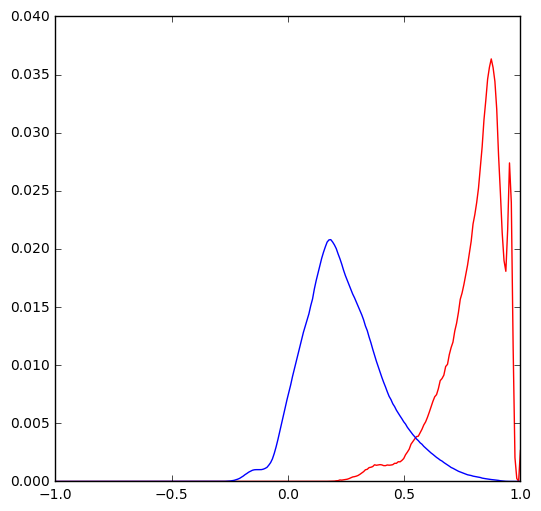

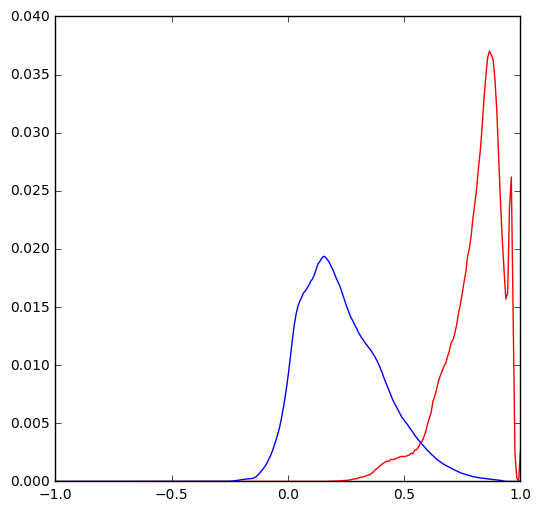

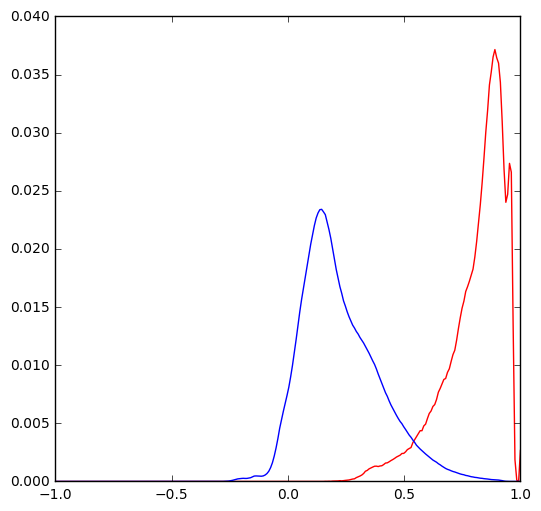

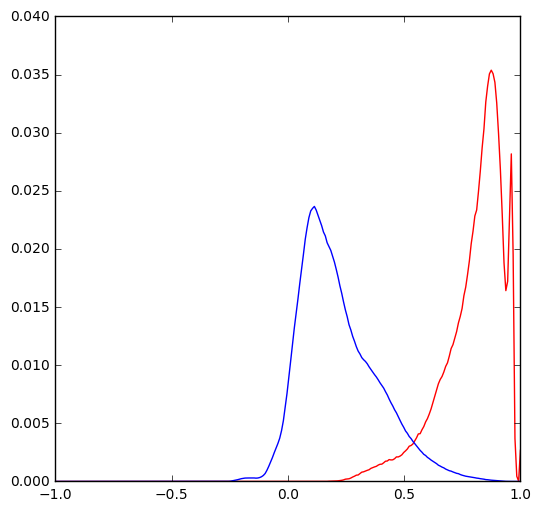

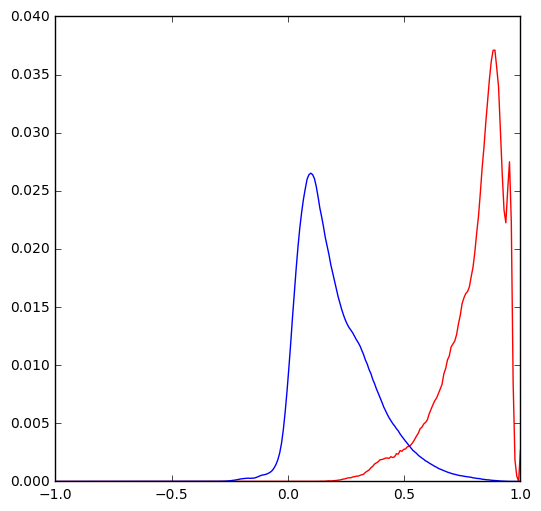

In [56]:
num_epochs = 50
num_save = 5

# lr.set_value(np.float32(1e-4))

for epoch in xrange(num_epochs):
    train_err = 0.
    
    start_time = time()
    for i, batch in enumerate(iterate_minibatches(train_vertices, train_faces, train_nFaces, train_labels, **config)):
        train_err_batch = train_fun(batch[0], 
                                    batch[1], batch[2], batch[3], batch[4], batch[5], 
                                    batch[6], batch[7], batch[8], batch[9], batch[10],
                                    batch[11])
        train_err += train_err_batch*len(batch[0])

        stdout.write('\rEpoch progress: {}/{}\t\tLoss: {:.5f}'
                     .format(config['batchsize']*(i+1),
                     len(train_nFaces)/config['batchsize']*config['batchsize'],
                     train_err/(config['batchsize']*(i+1))))
        stdout.flush()
    stdout.write('\n')
    stdout.flush()
        
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err/(config['batchsize']*(i+1))))

    if (epoch+1) % (num_epochs/num_save) == 0:
        config['mode'] = 'test'
        val_sims = sim_fun(val_vertices, val_faces, val_nFaces, **config)
        nh, ph = calc_hist(val_sims, val_labels, bin_num=config['bin_num'])
        fig = plt.figure(figsize=(6, 6))
        plt.plot(np.linspace(-1., 1., config['bin_num']), ph, c='red', figure=fig)
        plt.plot(np.linspace(-1., 1., config['bin_num']), nh, c='blue', figure=fig)
        fig.show()
        config['mode'] = 'train'
        
        dump_weights('./models/RT+AS+TR_1e-4_10.pkl', KDNet['desc_norm'])
        print '  Model saved!'